In [202]:
% some housekeeping stuff
register_graphics_toolkit ("gnuplot");
available_graphics_toolkits ();
graphics_toolkit ("gnuplot")
clear
% load packages
pkg load statistics
% end of housekeeping

error: package statistics is not installed
error: called from
    load_packages at line 47 column 7
    pkg at line 588 column 7


# The spectral resolution problem

 $$\mathbf{D} = \mathbf{CS^T}+\mathbf{E}$$
 
 $\mathbf{D}$ is the original data.  with rows of spectra measurements and columns corresponding to wavelength.
 
 $\mathbf{C}$ is the concentrations of the component spectra in $\mathbf{S}$.  and $\mathbf{E}$ is the error term.
 
So let's start by just making some data.  We will make up two spectra and make up concentrations.  Let's use gaussian function so we can make something that looks spectra like

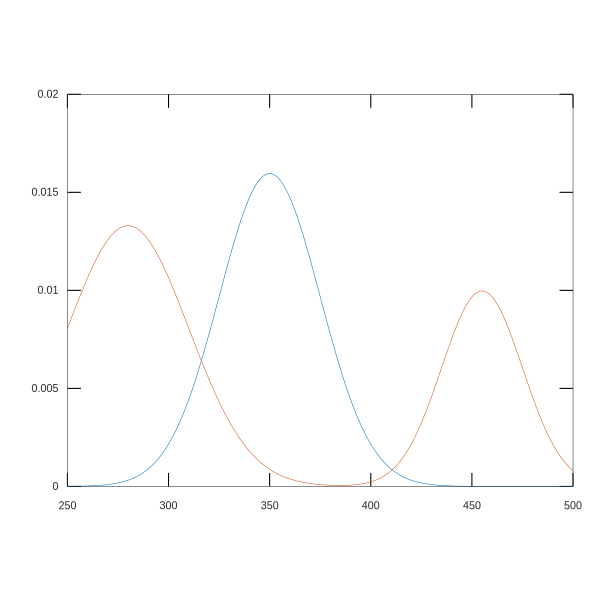

In [203]:
%plot -s 600,600 -f 'svg'

f = @(x,mu,sigma) (1/(sigma*sqrt(2*pi)))*exp((-1/2)*((x-mu)./sigma).^2);

x=[250:1:500]; % just arbitrary
mu1=350;sigma1=25; S1=f(x,mu1,sigma1);
mu2a=280; sigma2a=30; f2a=f(x,mu2a,sigma2a); mu2b=455; sigma2b=20; f2b=f(x,mu2b,sigma2b); 
S2=0.5*(2*f2a+f2b); 

plot(x,S1,x,S2)



now make up concentrations of each of S1 and S2.  Let's assume 10 solutions are made with different ratios of the two components.  Now we can make all the pretend data in $\mathbf{D}$

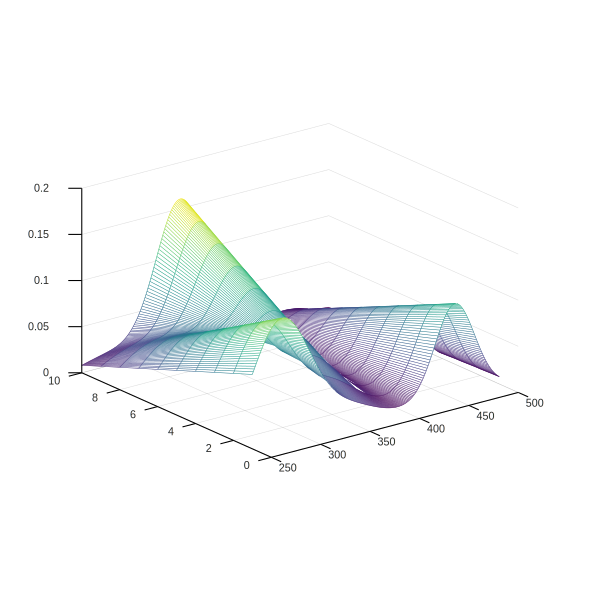

In [204]:
C1=[1 2 3 4 5 6 7 8 9 10];
C2=[10 9 8 7 6 5 4 3 2 1];

S=[S1' S2']; % spectra as two columns

C=[C1' C2']; % concentrations as two columns

D=C*S'; % this is the pretend data matrix

mesh(x,1:length(C),D); % plot the pretend data.

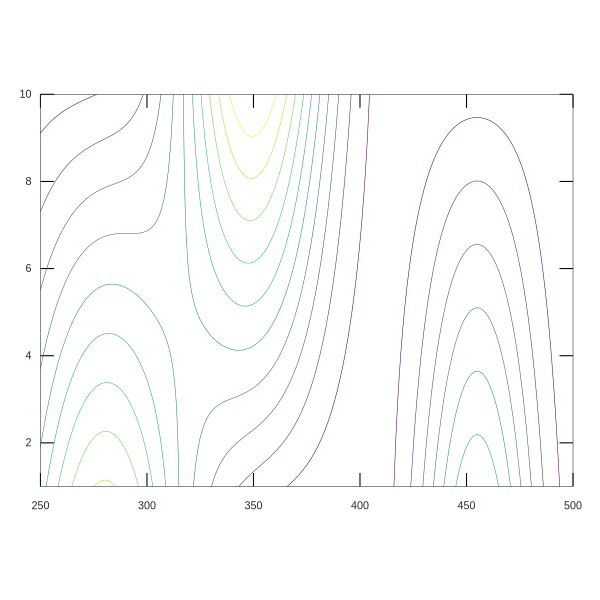

In [205]:
contour(x,1:length(C),D)

calculate the purity spectrum using the mean, stnadard deviation and alpha

$$ p_j = \dfrac{\sigma_j}{\mu_i+\alpha}$$

YOu can see what the offset parameter alpha does by comparing the two plots.  alpha is just determined by guessing and looking at the results.

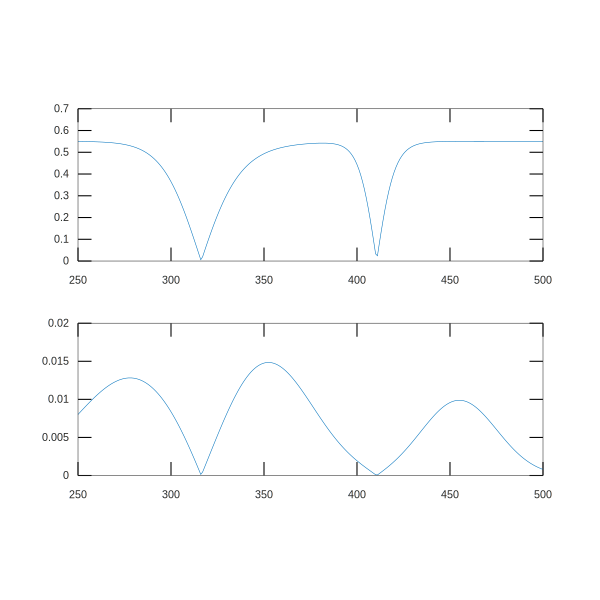

In [206]:
sigma=std(D); mu=mean(D); alpha=0; purity=sigma./(mu+alpha);
alpha=3; puritywithoffset=sigma./(mu+alpha);

subplot(211); plot(x,purity)
subplot(212); plot(x,puritywithoffset)

Now we know the first pure variable and that its concentration is proportional to the data at that wavelength.  use max of the purity spectrum to get this information

In [207]:
[maxpurevar,firstpureindex]=max(puritywithoffset)
wavelength=x(firstpureindex); 
conc1=D(:,firstpureindex)

maxpurevar = 0.014847
firstpureindex = 103
conc1 =

   0.023372
   0.038532
   0.053692
   0.068852
   0.084013
   0.099173
   0.114333
   0.129493
   0.144653
   0.159814



now we need to find the second pure variable.  we need to scale the data matrix to unit length.  the formula is 

$$D^\prime_{ij}=\dfrac{D_{ij}}{\sqrt{\mu_j^2+(\sigma_j+\alpha)^2}}$$

and the variance-covariance matrix

$$\mathbf{R}=\mathbf{D'}(\mathbf{D'}^\mathbf{T})$$

maxpurevar = 2.6771e-10
secondpureindex = 30


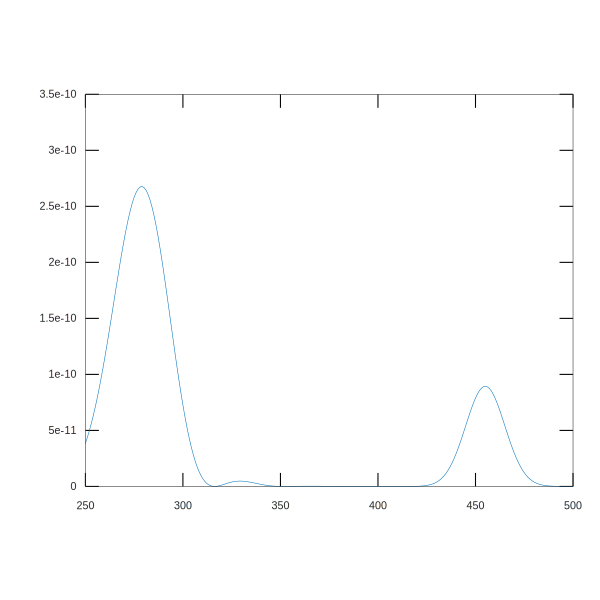

In [208]:
Dprime=D./sqrt(mu.^2+(sigma+alpha).^2);

F=length(conc1); % the number of samples

R=(1/F)*(Dprime'*Dprime); % equation wrong in the paper.

%now loop through to determine all the determinants for the weighting factors

for j=1:length(x)
    matrix=[R(j,j) R(j,firstpureindex); R(firstpureindex,j) R(firstpureindex,firstpureindex)];
    weight(j)=det(matrix);
end

purity2=((sigma.^2)./(mu.^2+alpha)).*weight;

plot(x,purity2)

% now get the second pure variable

[maxpurevar,secondpureindex]=max(purity2)
wavelength=x(secondpureindex); 
conc2=D(:,secondpureindex);

now calculate a third possible pure variable.  ou can see by the tiny intensities that all it took was two pure variables.

maxpurevar = 2.0541e-28
thirdpureindex = 108


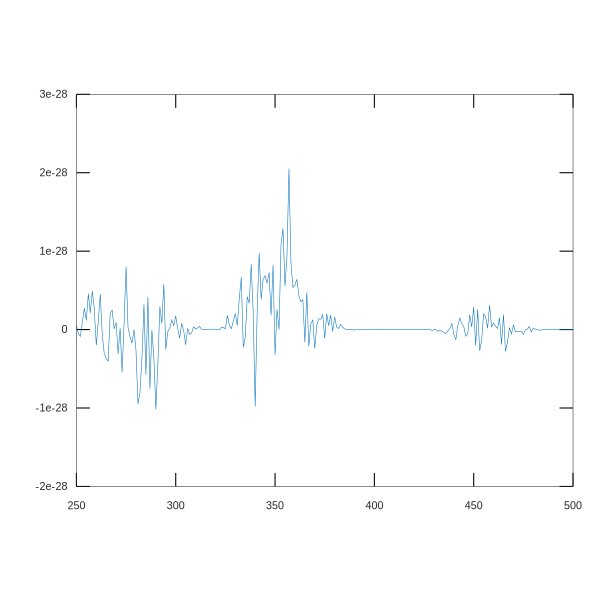

In [209]:
%now loop through to determine all the determinants for the weighting factors

for j=1:length(x)
    matrix=[...
    R(j,j) R(j,firstpureindex) R(j,secondpureindex)
    R(firstpureindex,j) R(firstpureindex,firstpureindex) R(firstpureindex,secondpureindex)
    R(secondpureindex,j) R(secondpureindex,firstpureindex) R(secondpureindex,secondpureindex)
    ];
    weight(j)=det(matrix);
end

purity3=((sigma.^2)./(mu.^2+alpha)).*weight;

plot(x,purity3)

% now get the second pure variable

[maxpurevar,thirdpureindex]=max(purity3)
wavelength=x(thirdpureindex); 
conc3=D(:,thirdpureindex);

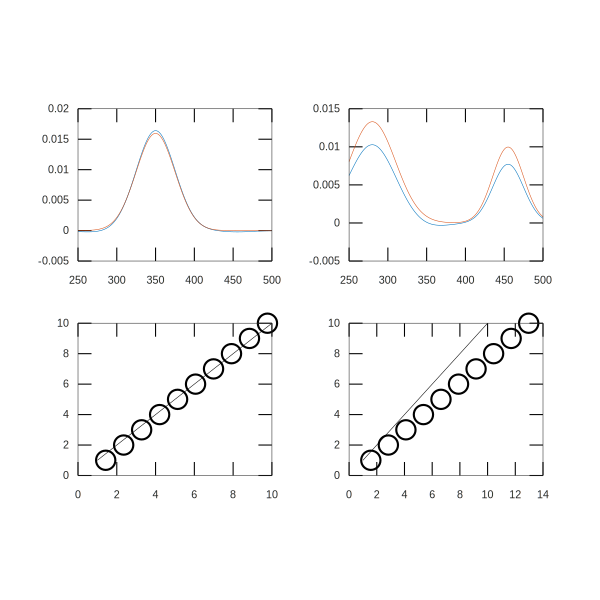

In [210]:
Dreduced=[conc1 conc2];

Sest=D'*Dreduced*inv(Dreduced'*Dreduced);

plot(x,Sest)

Cest=D*Sest*(inv(Sest'*Sest));

for i=1:length(Cest)
    F(i)=sum(D(i,:));
end

a=inv(Cest'*Cest)*Cest'*F';
A=diag(a);

Crevised=Cest*A;
Srevised=Sest*A*(inv(A'*A));

subplot(221)
plot(x,Srevised(:,1),x,S1)
subplot(222)
plot(x,Srevised(:,2),x,S2)
subplot(223)
plot(Crevised(:,1),C1,'ko',C1,C1,'k-')
subplot(224)
plot(Crevised(:,2),C2,'ko',C2,C2,'k-')